In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray as xr
import xbout
from pathlib import Path
import xhermes as xh
import matplotlib.pyplot as plt
import os, sys, pathlib
import numpy as np
import xarray as xr
import xhermes as xh

sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/sdtools"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/general_functions"))

from convergence_functions import *

from matplotlib.ticker import LogFormatter

sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/sdtools"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/transients"))
sys.path.append(os.path.join(r"/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/my_notebooks/notebooks/hermes-3/general_functions"))


from plotting_functions import *
from convergence_functions import * 

from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.fluxes import *


# plt.style.use('ggplot')
plt.rcParams.update({'font.size': 10})
linewidth = 3
markersize = 15



# plt.style.use('ggplot')
plt.style.use('default')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 16})



%load_ext autoreload
%autoreload 2


In [12]:


def plot_time_history(dataset, variables=['Te'], upstream_index=2, target_index=-2,
                      track_detachment_front=False, time_slices=200,
                      log_threshold=1e6, base_figsize=(6, 4)):
    """
    Plots the time history of user-specified variables at upstream and target positions
    on separate plots, using the last 200 time slices or the maximum available.

    Optionally tracks the detachment front, where Nd > Ne, and adds it as a separate subplot.

    Parameters:
    dataset (xarray Dataset): Hermes-3 dataset.
    variables (list): List of variables to plot (e.g., ['Te', 'Td+', 'Ne']).
    upstream_index (int): Index for the upstream data.
    target_index (int): Index for the target data.
    track_detachment_front (bool): If True, track the location where Nd > Ne
                                   and show it as a separate subplot.
    log_threshold (float): Threshold above which the y-axis will be plotted in log scale.
    base_figsize (tuple): Base figure size for a single plot (width, height).
    """
    # Determine how many time steps to plot (maximum 200 or the total available)
    num_time_slices = min(time_slices, dataset.sizes['t'])

    # Select the last `num_time_slices` time steps
    selected_steps = dataset.isel(t=slice(-num_time_slices, None))
    times = selected_steps['t'].values  # Corresponding time values
    t_conversion = dataset['t'].attrs.get('conversion', 1.0)
    times = times * t_conversion  # Convert to seconds if necessary

    # Adjust the number of subplots based on whether we're tracking detachment front
    total_vars = len(variables) + (1 if track_detachment_front else 0)

    # Dynamically scale figure size based on number of variables
    figsize = (base_figsize[0] * total_vars, base_figsize[1] * 2)

    # Create figure with subplots, one set for upstream and one for target, plus detachment front if enabled
    fig, axs = plt.subplots(2, total_vars, figsize=figsize, dpi=500)

    # Ensure axs is treated as a list if there's only one plot
    if total_vars == 1:
        axs = [axs[0], axs[1]]

    axs = np.ravel(axs)  # Flatten the axes for easy handling

    # Variable to store positions where Nd > Ne (detachment front)
    detachment_front_positions = [] if track_detachment_front else None

    # If tracking the detachment front, calculate it for each time slice
    if track_detachment_front:
        front_positions = []
        for t_step in range(num_time_slices):
            ds_at_t = selected_steps.isel(t=t_step)
            front_loc = detachment_front_finder(ds_at_t)
            front_positions.append(front_loc)
        detachment_front_positions = np.array(front_positions)

    # Iterate over each variable to plot upstream and target values
    for i, var in enumerate(variables):
        # Extract upstream and target data for each variable
        upstream_data = np.squeeze(selected_steps[var].isel(y=upstream_index).values)
        target_data = np.squeeze(selected_steps[var].isel(y=target_index).values)

        # Check if data exceeds the threshold, and use log scale if so
        if np.max(np.abs(upstream_data)) > log_threshold or np.max(np.abs(target_data)) > log_threshold:
            scale = "log"
        else:
            scale = "linear"

        # Plot upstream data on the top row
        axs[i].plot(times, upstream_data, label=f'Upstream {var}', marker='o', linestyle='-')
        axs[i].set_title(f'Upstream {var}')
        axs[i].set_xlabel('Time (s)')
        axs[i].set_ylabel(f'{var} ({dataset[var].attrs.get("units", "Unknown units")})')
        axs[i].grid(True)
        axs[i].set_yscale(scale)

        # Apply custom log formatter for log scale
        if scale == "log":
            axs[i].yaxis.set_major_formatter(log_formatter())

        # Plot target data on the bottom row
        axs[i + total_vars].plot(times, target_data, label=f'Target {var}', marker='x', linestyle='--')
        axs[i + total_vars].set_title(f'Target {var}')
        axs[i + total_vars].set_xlabel('Time (s)')
        axs[i + total_vars].set_ylabel(f'{var} ({dataset[var].attrs.get("units", "Unknown units")})')
        axs[i + total_vars].grid(True)
        axs[i + total_vars].set_yscale(scale)

        # Apply custom log formatter for target plot
        if scale == "log":
            axs[i + total_vars].yaxis.set_major_formatter(log_formatter())

    # Add a separate subplot for the detachment front position if requested
    if track_detachment_front:
        detachment_front_index = len(variables)  # The next index after all variables
        axs[detachment_front_index].plot(times, detachment_front_positions, marker='s', linestyle='-', color='red',
                                         label='Nd > Ne Front')
        axs[detachment_front_index].set_title('Detachment Front Position (Nd > Ne)')
        axs[detachment_front_index].set_xlabel('Time (s)')
        axs[detachment_front_index].set_ylabel('Position (m)')
        axs[detachment_front_index].grid(True)

        # Plot the same on the bottom row
        axs[detachment_front_index + total_vars].plot(times, detachment_front_positions, marker='s', linestyle='-', color='red',
                                                      label='Nd > Ne Front')
        axs[detachment_front_index + total_vars].set_title('Detachment Front Position (Nd > Ne)')
        axs[detachment_front_index + total_vars].set_xlabel('Time (s)')
        axs[detachment_front_index + total_vars].set_ylabel('Position (m)')
        axs[detachment_front_index + total_vars].grid(True)

    plt.tight_layout()
    
    return axs

In [3]:
FL_CD = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2024-09_glimmer_steady_state_base/FL/CD/5.0_MA')
FL_SXD = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2024-09_glimmer_steady_state_base/FL/SXD/case_02_collisions_fixed_sheath')
SNB_CD = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2024-09_glimmer_steady_state_base/SNB/CD/5.0_MA_SNB')
SNB_SXD = xh.open('/users/jlb647/scratch/simulation_program/hermes-3_sim/simulation_dir/2024-09_glimmer_steady_state_base/SNB/SXD/case_09_Increase_to_glimmer_params')

/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/hermes-3_venv/lib/python3.11/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/hermes-3_venv/lib/python3.11/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/users/jlb647/scratch/simulation_program/hermes-3_sim/analysis/hermes-3_venv/lib/python3.11/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tu

# FL

## CD


### Profiles

<Figure size 2500x2000 with 0 Axes>

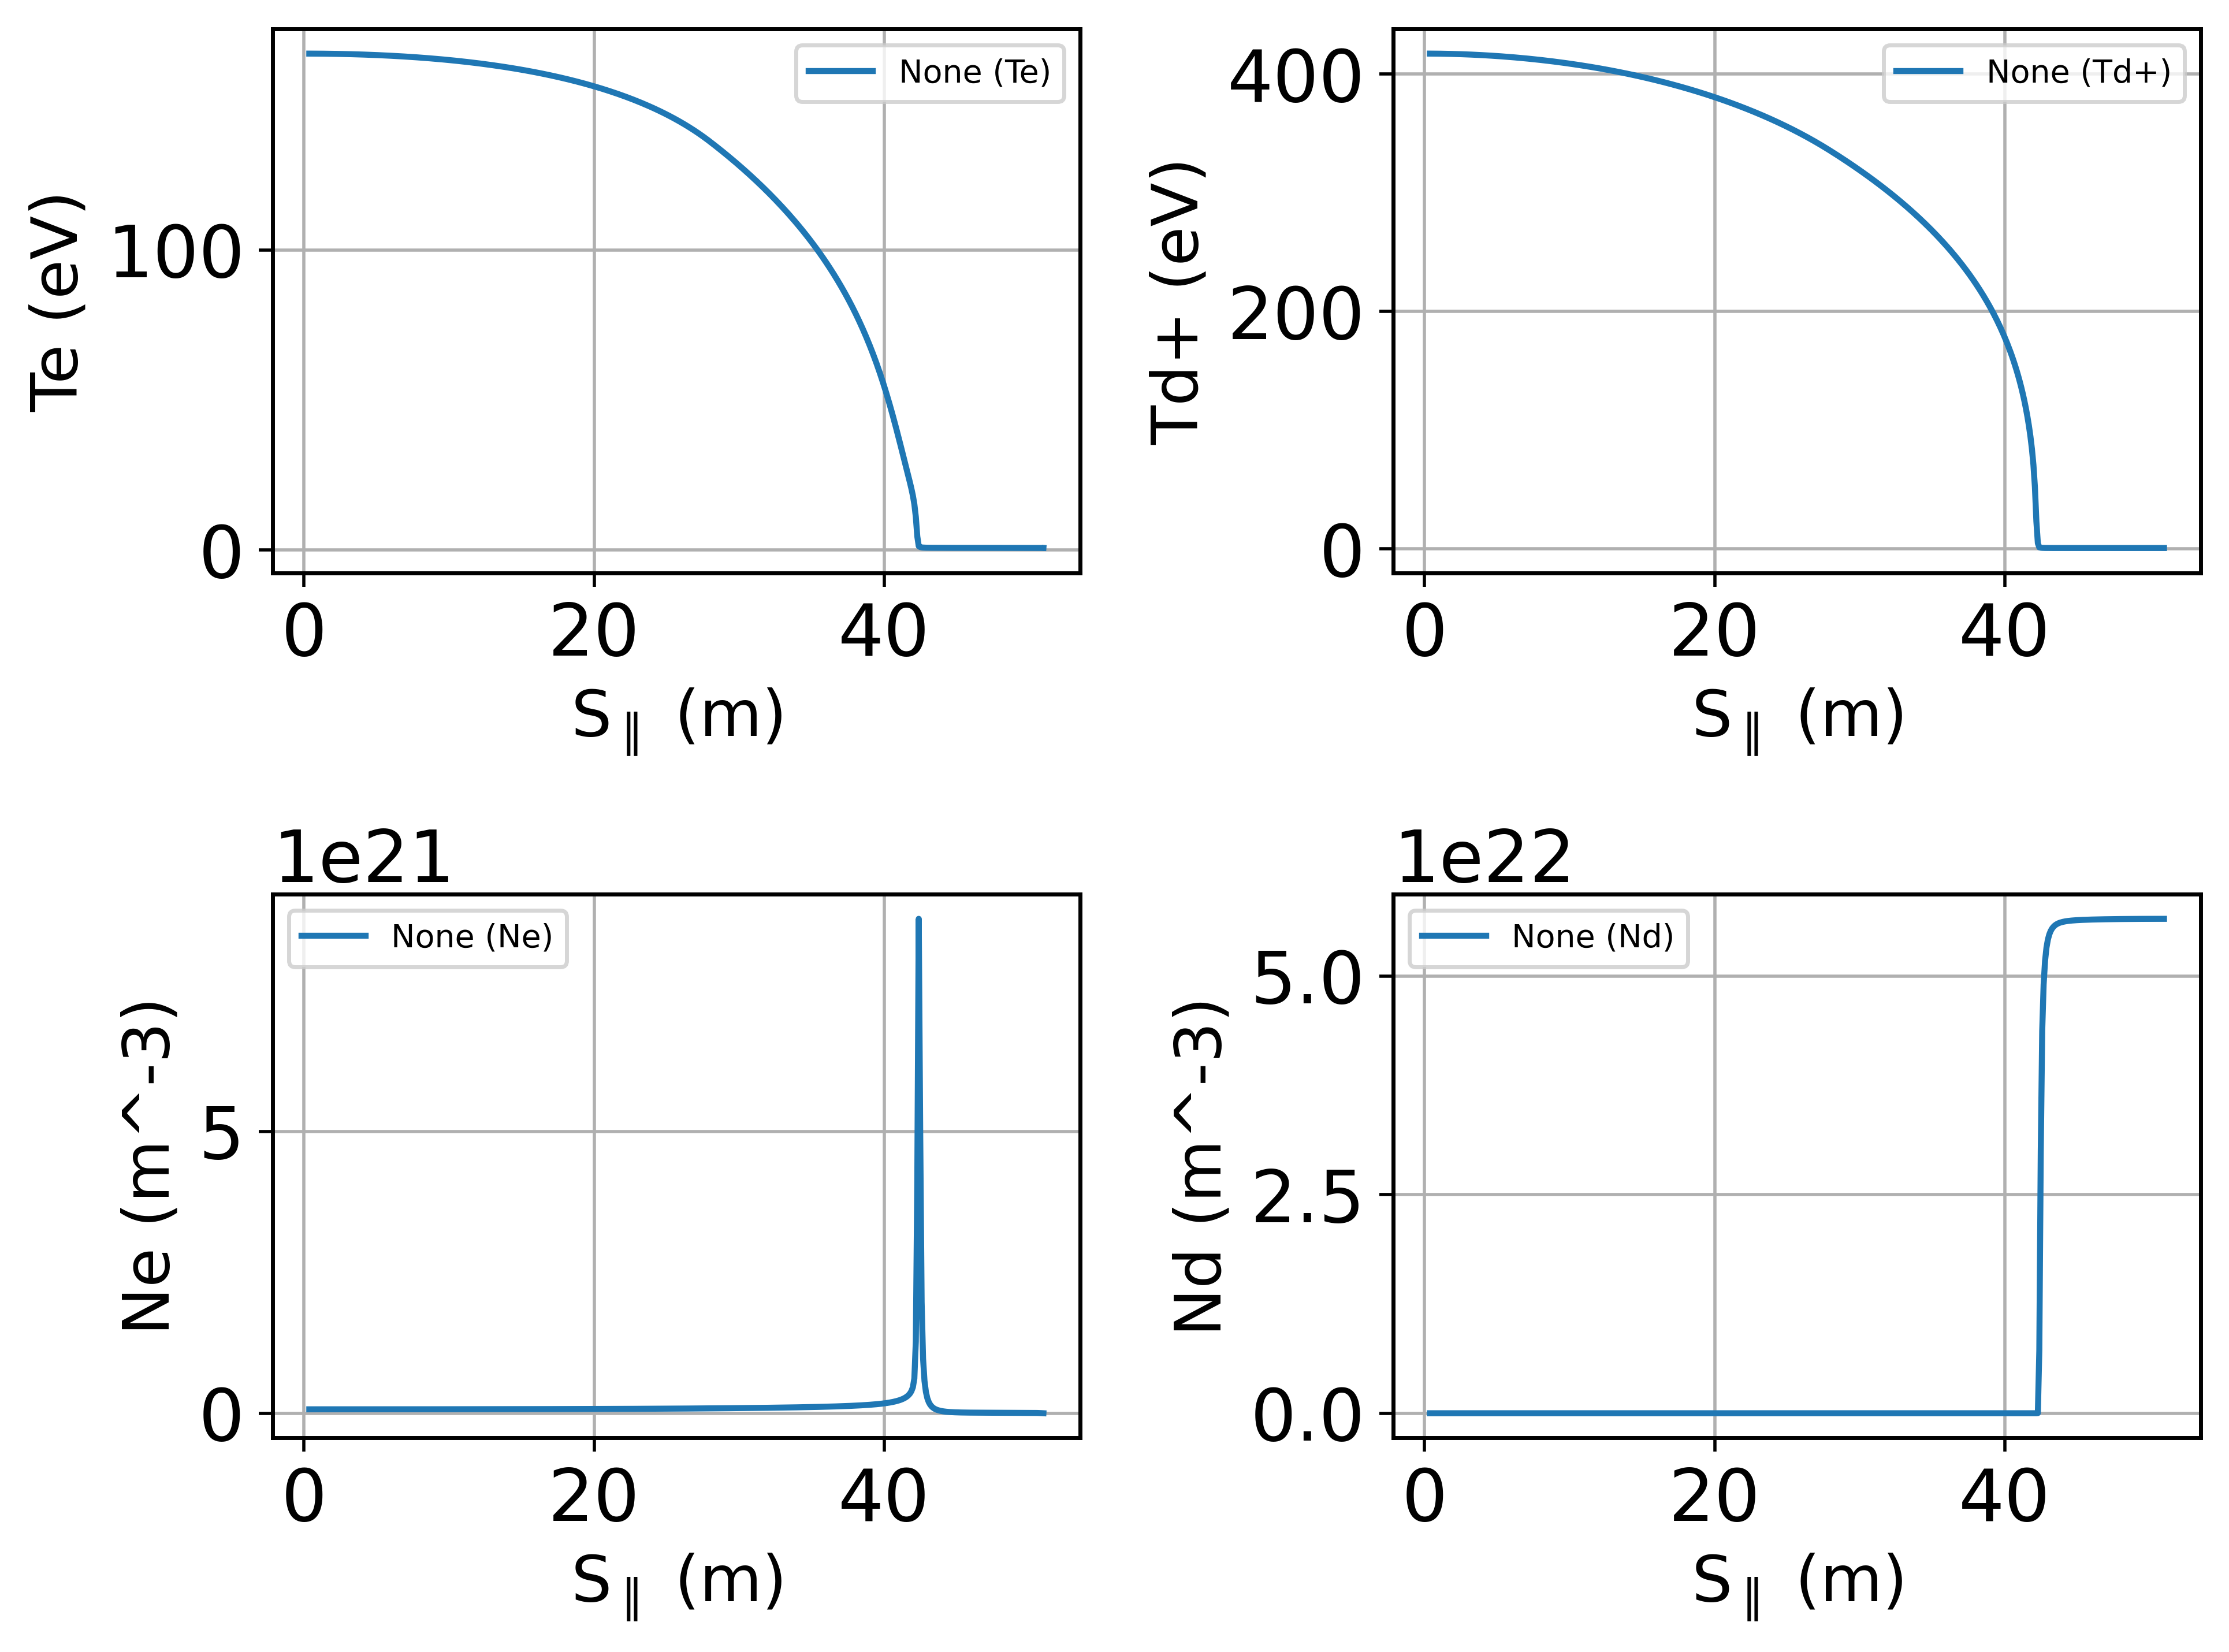

In [15]:
plt.figure(figsize=(10, 8), dpi = 250)
axs = plot_profiles(FL_CD, ['Te','Td+','Ne','Nd'])

# Get the current figure from one of the axes and adjust the size
fig = axs[0].figure
fig.set_size_inches(10, 8)  # Set the desired size

# Optionally, re-render the layout and show the figure
fig.tight_layout()
plt.show()

### Time History

NameError: name 'log_formatter' is not defined

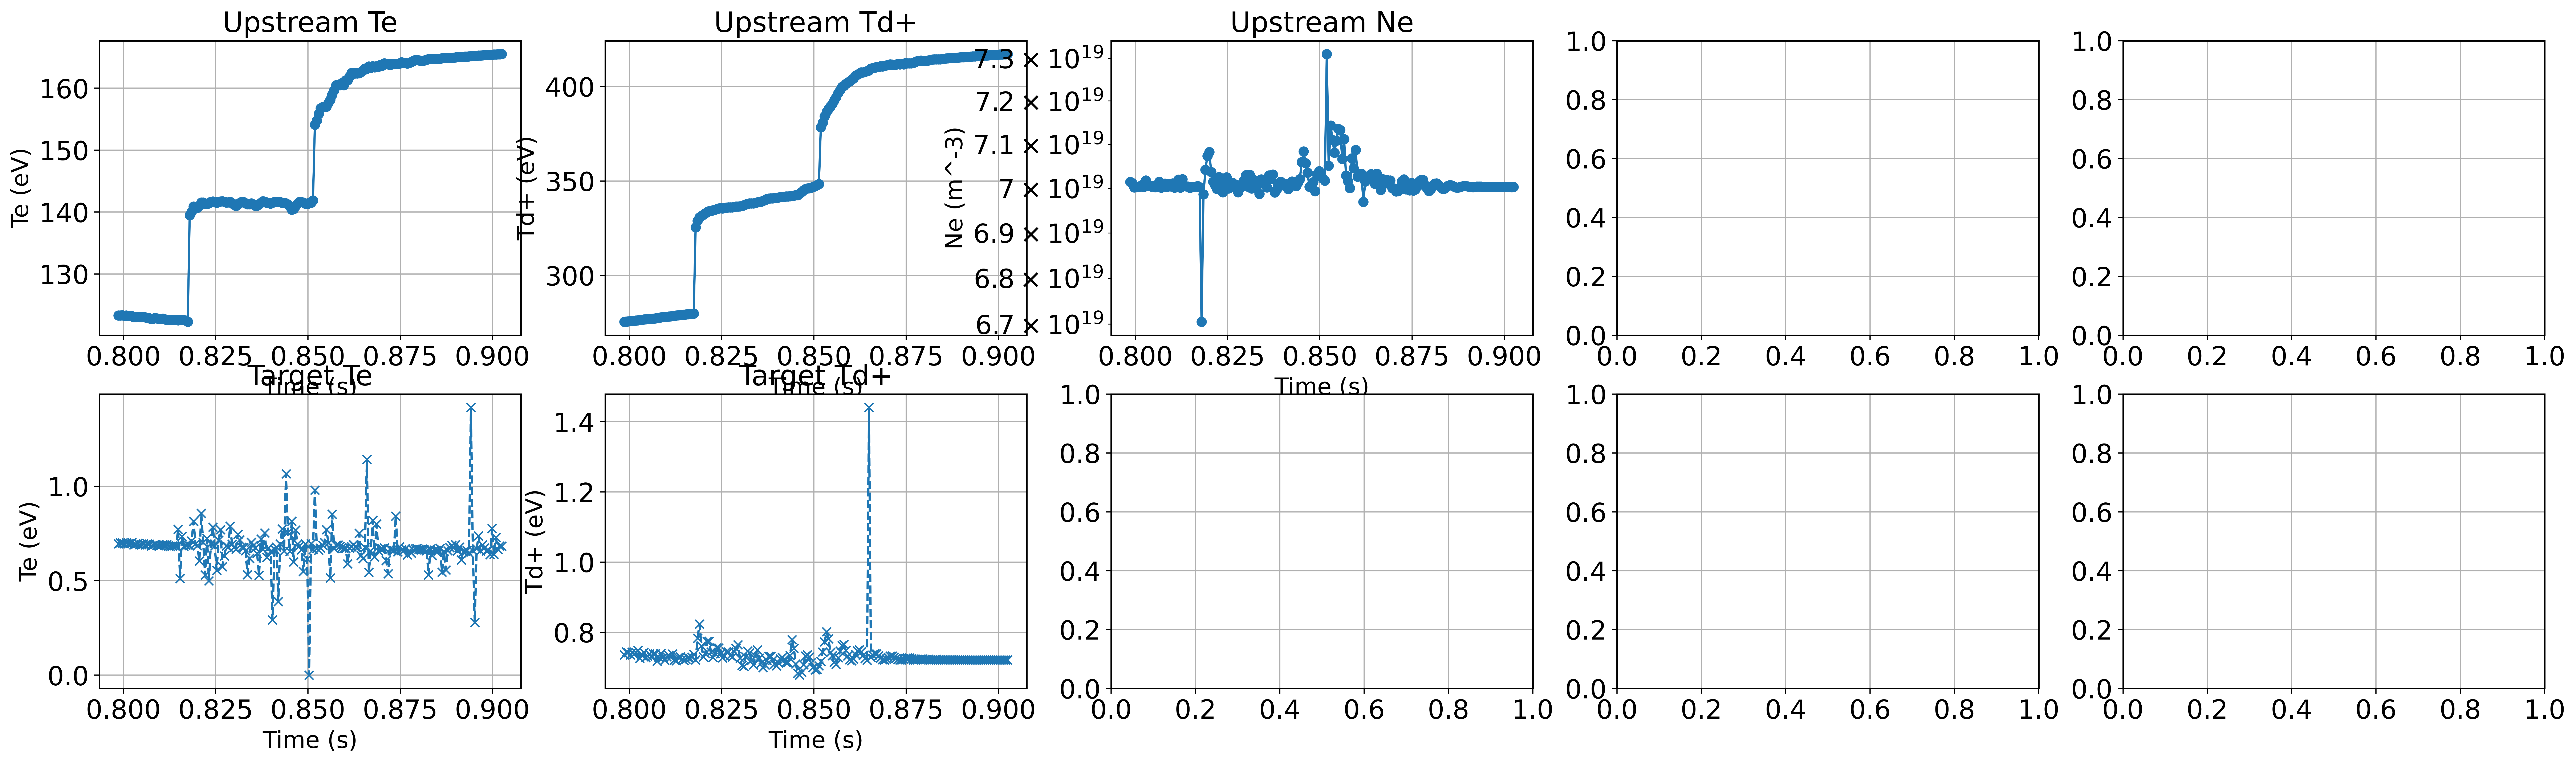

In [10]:
plot_time_history(FL_CD, ['Te','Td+','Ne','Nd'], track_detachment_front=True)

## SXD

### Profiles

In [2]:
coef0 = 1.7597676684e+00		# Manually setting the flux expansion with a profile from the equilibrium files
coef1 = 4.1883560155e-01		# Very hacky but it gets the job done
coef2 = -4.6906367245e+00		# area_expansion normally does a good enough job
coef3 = 7.3174700447e+00
coef4 = -5.7251396733e+00
coef5 = 2.6799740048e+00
coef6 = -7.9457620000e-01
coef7 = 1.5075033673e-01
coef8 = -1.7757965412e-02
coef9 = 1.1834284917e-03
coef10 = -3.4102000406e-05

y = np.linspace(0,2*np.pi,100)


J = 0  + y^0*coef0 + y^1*coef1 + y^2*coef2 + y^3*coef3 + y^4*coef4 + y^5*coef5 + y^6*coef6 + y^7*coef7 + y^8*coef8 + y^9*coef9 + y^10*coef10

TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''



plot_profiles()